In [1]:
# ============================================================
# Online Retail II – EDA, RFM, dan Segmentasi di Google Colab
# ============================================================

# (Opsional) Install paket – biasanya Colab sudah punya
# !pip install pandas numpy matplotlib scikit-learn openpyxl

import os
import io
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set opsi tampilan
pd.set_option('display.max_columns', 100)

OUT_DIR = Path("/content/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Siap. Lanjut ke sel berikutnya untuk unggah data.")


Siap. Lanjut ke sel berikutnya untuk unggah data.


In [2]:
# =====================================
# Unggah data (pilih salah satu berkas)
# =====================================
# Opsi A: Upload CSV hasil bersih (online_retail_ii_clean.csv)
# Opsi B: Upload Excel asli (mis. Online Retail II xlsx) atau ZIP berisi Excel tersebut

from google.colab import files

uploaded = files.upload()  # pilih 1 file
fname = list(uploaded.keys())[0]
print("File terunggah:", fname)


Saving online+retail+ii.zip to online+retail+ii (1).zip
File terunggah: online+retail+ii (1).zip


In [3]:
# ==================================================
# Loader serbaguna: CSV bersih / Excel / ZIP ber-Excel
# ==================================================

def load_online_retail_ii_from_uploaded(path: str, max_rows_per_sheet: int = None) -> pd.DataFrame:
    """
    Memuat dataset dari:
    - CSV bersih (punya kolom InvoiceDate, Quantity, Price, dst.)
    - Excel (xlsx/xls) yang memiliki 1–2 sheet Online Retail II
    - ZIP yang berisi Excel
    Argumen:
      max_rows_per_sheet: batasi baris per sheet jika file sangat besar (None = muat semua)
    """
    p = Path(path)
    if p.suffix.lower() == ".csv":
        df = pd.read_csv(p, parse_dates=["InvoiceDate"], dayfirst=False, infer_datetime_format=True)
        # Normalisasi nama kolom
        df.columns = [c.strip().replace(" ", "_").replace("/", "_") for c in df.columns]
        return df

    if p.suffix.lower() in [".xlsx", ".xls"]:
        xl = pd.ExcelFile(p)
        frames = []
        # Muat hanya kolom penting untuk percepat
        needed = ["Invoice","InvoiceNo","StockCode","Description","Quantity","InvoiceDate",
                  "UnitPrice","Price","Customer ID","CustomerID","Customer_ID","Country"]
        for sheet in xl.sheet_names:
            # baca header untuk mapping kolom
            head = pd.read_excel(xl, sheet_name=sheet, nrows=2, engine="openpyxl")
            usecols = [c for c in head.columns if c in needed]
            df_s = pd.read_excel(xl, sheet_name=sheet, usecols=usecols,
                                 nrows=max_rows_per_sheet, engine="openpyxl")
            frames.append(df_s)
        df = pd.concat(frames, ignore_index=True, sort=False)
        df.columns = [c.strip().replace(" ", "_").replace("/", "_") for c in df.columns]
        return df

    if p.suffix.lower() == ".zip":
        with zipfile.ZipFile(p, 'r') as zf:
            # cari xlsx/xls di dalam ZIP
            excel_names = [n for n in zf.namelist() if n.lower().endswith((".xlsx",".xls"))]
            if not excel_names:
                raise ValueError("ZIP tidak berisi file Excel.")
            # ambil file excel pertama
            with zf.open(excel_names[0]) as f:
                xl = pd.ExcelFile(io.BytesIO(f.read()))
                frames = []
                needed = ["Invoice","InvoiceNo","StockCode","Description","Quantity","InvoiceDate",
                          "UnitPrice","Price","Customer ID","CustomerID","Customer_ID","Country"]
                for sheet in xl.sheet_names:
                    head = pd.read_excel(xl, sheet_name=sheet, nrows=2, engine="openpyxl")
                    usecols = [c for c in head.columns if c in needed]
                    df_s = pd.read_excel(xl, sheet_name=sheet, usecols=usecols,
                                         nrows=max_rows_per_sheet, engine="openpyxl")
                    frames.append(df_s)
                df = pd.concat(frames, ignore_index=True, sort=False)
                df.columns = [c.strip().replace(" ", "_").replace("/", "_") for c in df.columns]
                return df

    raise ValueError("Format file tidak dikenali. Gunakan CSV/Excel/ZIP.")

raw = load_online_retail_ii_from_uploaded(fname, max_rows_per_sheet=None)
print("Dimensi data mentah:", raw.shape)
raw.head()


Dimensi data mentah: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# ==================
# Pembersihan dasar
# ==================
df = raw.copy()

# Harmonisasi nama kolom umum
if "InvoiceNo" in df.columns and "Invoice" not in df.columns:
    df["Invoice"] = df["InvoiceNo"]
if "CustomerID" in df.columns and "Customer_ID" not in df.columns:
    df["Customer_ID"] = df["CustomerID"]
if "UnitPrice" in df.columns and "Price" not in df.columns:
    df["Price"] = df["UnitPrice"]

expected = ["Invoice","StockCode","Description","Quantity","InvoiceDate","Price","Customer_ID","Country"]
for c in expected:
    if c not in df.columns:
        df[c] = np.nan

# Tipe data
df["Invoice"] = df["Invoice"].astype(str)
df["StockCode"] = df["StockCode"].astype(str)
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Customer_ID"] = pd.to_numeric(df["Customer_ID"], errors="coerce")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Drop baris invalid kunci
df = df.dropna(subset=["InvoiceDate","Quantity","Price"])

# Tandai pembatalan: Invoice diawali 'C'
df["IsCancellation"] = df["Invoice"].str.startswith("C", na=False)

# Revenue baris
df["Revenue"] = df["Quantity"] * df["Price"]

# Filter transaksi valid
df = df[(~df["IsCancellation"]) & (df["Quantity"] > 0) & (df["Price"] > 0)].copy()

# Kolom waktu bantu
df["InvoiceMonth"] = df["InvoiceDate"].values.astype("datetime64[M]")
df["InvoiceYear"]  = df["InvoiceDate"].dt.year

print("Dimensi setelah cleaning:", df.shape)
df.head()


Dimensi setelah cleaning: (1041670, 12)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,IsCancellation,Revenue,InvoiceMonth,InvoiceYear
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False,83.4,2009-12-01,2009
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,81.0,2009-12-01,2009
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,81.0,2009-12-01,2009
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False,100.8,2009-12-01,2009
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False,30.0,2009-12-01,2009


In [5]:
# =====================
# KPI dan ringkasan
# =====================
kpis = {
    "Total_Revenue": float(df["Revenue"].sum()),
    "Invoices": int(df["Invoice"].nunique()),
    "Unique_Customers": int(df["Customer_ID"].nunique()),
    "Unique_SKUs": int(df["StockCode"].nunique()),
    "Avg_Order_Value": float(df.groupby("Invoice")["Revenue"].sum().mean())
}
kpi_df = pd.DataFrame(list(kpis.items()), columns=["KPI","Value"])
kpi_path = OUT_DIR / "kpis.csv"
kpi_df.to_csv(kpi_path, index=False)
kpi_df


,KPI,Value
0,Total_Revenue,2.097259e+07
1,Invoices,4.007700e+04
2,Unique_Customers,5.878000e+03
3,Unique_SKUs,4.917000e+03
4,Avg_Order_Value,5.233075e+02


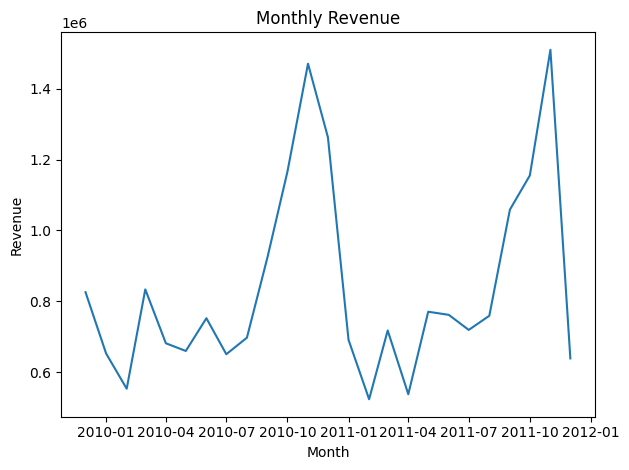

In [6]:
# ============================
# Tren Revenue Bulanan (Plot)
# ============================
monthly_rev = (
    df.groupby("InvoiceMonth")["Revenue"]
      .sum()
      .sort_index()
      .reset_index()
)

# Simpan & tampilkan plot (1 figure saja)
plt.figure()
plt.plot(monthly_rev["InvoiceMonth"], monthly_rev["Revenue"])
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

monthly_rev.to_csv(OUT_DIR / "monthly_revenue.csv", index=False)


In [7]:
# ==============================
# Top 10 Negara berdasarkan Revenue
# ==============================
country_rev = (
    df.groupby("Country", dropna=False)["Revenue"]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)
country_top10 = country_rev.head(10)
country_top10.to_csv(OUT_DIR / "top_countries_by_revenue.csv", index=False)
country_top10


,Country,Revenue
0,United Kingdom,1.787098e+07
1,EIRE,6.644318e+05
2,Netherlands,5.542323e+05
3,Germany,4.312625e+05
4,France,3.569446e+05
5,Australia,1.699681e+05
6,Spain,1.091785e+05
7,Switzerland,1.010113e+05
8,Sweden,9.190372e+04
9,Denmark,6.986219e+04


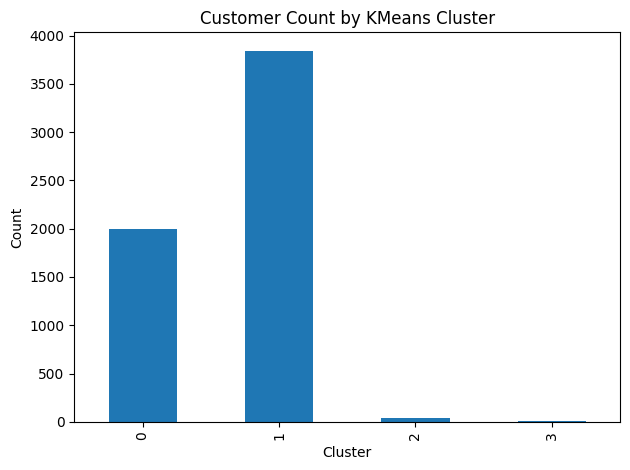

,Cluster,Recency,Frequency,Monetary,RFM_Score
0,0,463.032032,2.212212,765.244446,5.610110
1,1,67.005728,7.307732,3009.402451,10.706326
2,2,25.942857,103.714286,83086.079771,14.571429
3,3,3.500000,212.500000,436835.792500,15.000000


In [8]:
# ============================
# Analisis RFM + KMeans (k=4)
# ============================
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer_ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency (lebih kecil lebih baik)
    "Invoice": "nunique",                                     # Frequency
    "Revenue": "sum"                                          # Monetary
}).rename(columns={"InvoiceDate":"Recency","Invoice":"Frequency","Revenue":"Monetary"}).dropna()

# Skor kuantil 1–5
rfm["R"] = pd.qcut(rfm["Recency"].rank(method="first", ascending=True), 5, labels=[5,4,3,2,1]).astype(int)
rfm["F"] = pd.qcut(rfm["Frequency"].rank(method="first", ascending=True), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M"] = pd.qcut(rfm["Monetary"].rank(method="first", ascending=True), 5, labels=[1,2,3,4,5]).astype(int)
rfm["RFM_Score"] = rfm[["R","F","M"]].sum(axis=1)

# Standarisasi fitur untuk KMeans
scaler = StandardScaler()
X = scaler.fit_transform(rfm[["Recency","Frequency","Monetary"]].values)

# KMeans
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(X)

# Profil cluster
cluster_profile = rfm.groupby("Cluster")[["Recency","Frequency","Monetary","RFM_Score"]].mean().reset_index()
cluster_counts = rfm["Cluster"].value_counts().sort_index()

# Simpan
rfm.to_csv(OUT_DIR / "rfm_full.csv")
cluster_profile.to_csv(OUT_DIR / "cluster_profile.csv", index=False)

# Plot jumlah pelanggan per cluster (1 figure)
plt.figure()
cluster_counts.plot(kind="bar")
plt.title("Customer Count by KMeans Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

cluster_profile


In [9]:
# ==============================================
# (Opsional) Cek kualitas cluster (Silhouette)
# ==============================================
try:
    sil = silhouette_score(X, rfm["Cluster"])
    print(f"Silhouette score (k={k}): {sil:.4f}")
except Exception as e:
    print("Gagal hitung silhouette:", e)


Silhouette score (k=4): 0.5905


In [10]:
# ===========================
# Simpan semua output ke ZIP
# ===========================
import shutil
zip_path = "/content/online_retail_ii_outputs.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)
shutil.make_archive("/content/online_retail_ii_outputs", "zip", OUT_DIR)
print("ZIP siap:", zip_path)

# Di Colab, Anda bisa jalankan:
# from google.colab import files
# files.download("/content/online_retail_ii_outputs.zip")


ZIP siap: /content/online_retail_ii_outputs.zip
